In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
import re

In [10]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [11]:
CMO = pd.concat([pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(raw_dir+'smi_acute.xlsx', sheet_name = 'last')], axis =0).drop(['INPUT','FOUND_BY'],axis=1)


In [12]:
CHM0 = CMO[CMO["SMILES"]!='-']
CHM0.head()

,DTXSID,PREFERRED_NAME,SMILES,QSAR_READY_SMILES
0,DTXSID5020281,1-Chloro-4-nitrobenzene,[O-][N+](=O)C1=CC=C(Cl)C=C1,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,DTXSID8020961,4-Nitroaniline,NC1=CC=C(C=C1)[N+]([O-])=O,NC1=CC=C(C=C1)[N+]([O-])=O
2,DTXSID0021834,4-Nitrophenol,OC1=CC=C(C=C1)[N+]([O-])=O,OC1=CC=C(C=C1)[N+]([O-])=O
3,DTXSID2044347,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(C)=O
4,DTXSID4025745,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1


In [13]:
AIM_FP = pd.read_csv(raw_dir+'CHM0_apr14_aim.txt',sep=';')
AIM_FP = AIM_FP[AIM_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
AIM_FP = AIM_FP.iloc[:,0:-2]
AIM_FP = AIM_FP.set_index('M_NAME').rename_axis(index=None)

print(AIM_FP.shape)
# # Remove duplicates (FOR AIM)
## WARNING:
## 5/5/22 -- this MIGHT not working properly 
# ex: 341C and 71E are the same
## checking the duplicates 


col_names = []
for i in AIM_FP.columns:
    col_names.append(i.split('.')[0])    
mylist = Counter(col_names)
duplicate_list= {key: value for key, value in mylist.items() if value > 1}

len_dict = len(duplicate_list)
sum_dict = sum(duplicate_list.values())
print(f'{sum_dict-len_dict} columns to be removed')

cols = []
for i in AIM_FP.columns:
    if i.split('.')[0] in duplicate_list.keys():
        cols.append(i)
        
df_dupes =AIM_FP[cols].copy()
for i,col in enumerate(df_dupes):
    col_1 = df_dupes.iloc[:,i].name.split('.')[0]
    # Match columns which are duplicates (e.g. Mercury [Measured] and Mercury [Measured].1 ) by name
    for j, col2 in enumerate(df_dupes):
        col_2 = df_dupes.iloc[:,j].name.split('.')[0]
            # If match, then column values will be updated to maximum value across the two columns for each row
        if col_1 == col_2:
            df_dupes[col] = df_dupes[[col,col2]].max(axis=1)
    
    
    
n_before = AIM_FP.shape[1]
for col in df_dupes:
    # Remove duplicate columns which are not the first (indicated by ending in  .[1-9])
    if re.search('\.[1-9]$',col) is not None:
        AIM_FP = AIM_FP.drop(columns=[col])
    else:
        AIM_FP[col] = df_dupes[col]
    
    

n_after = AIM_FP.shape[1]

print(f'{n_before-n_after} columns removed')


AIM_FP = AIM_FP.dropna(axis=1)
print(AIM_FP.shape)
AIM_FP.head()

(6972, 902)
117 columns to be removed
117 columns removed
(6972, 785)


,CH3 [aliphatic carbon],CH2 [aliphatic carbon],CH [aliphatic carbon],"C [aliphatic carbon No H, not tert]",=CH2 [olefinic carbon],=CH or =C [olefinc carbon],#C [acetylenic carbon],"OH [hydroxy, aliphatic attach]","O [oxygen, aliphatic attach]",NH2 [aliphatic attach],...,N CH=N OH [oxime type] correction,Ring rx: OH ortho to C=N N carbon,=C (C#N) C#N [dicyano] correction,Aromatic nitrogen C C(=S) N struct corr.,Cyclic ketoxime(>C=N OH) [1 olefin attach],C=N O sulfur(aliphatic) [iminoxy] correc,S N( C(=O) C) C(=O) C struct correction,Sulfur(+4) charged halide type,Ring rx: S=P(O)(O)O / 5 mem (2 nitrogen),O=P( O)( O) C OH correction
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
Toxprint_FP = pd.read_csv(raw_dir+'CHM0_apr1_tox.txt',sep=';')
Toxprint_FP = Toxprint_FP[Toxprint_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
Toxprint_FP = Toxprint_FP.iloc[:,0:-2]
Toxprint_FP = Toxprint_FP.set_index('M_NAME').rename_axis(index=None)
#Toxprint_FP.to_pickle(processed_dir+'Toxprint_FP.pkl')
Toxprint_FP.head()


,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

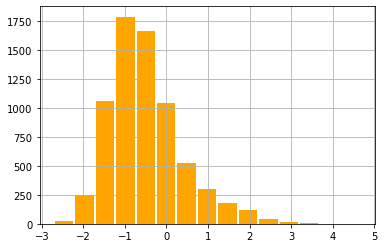

In [16]:
POD0 = pd.read_csv(raw_dir+'small_acute_processed.csv').set_index('dsstox_sid')
POD0.LD50_LM.hist(bins=15,rwidth=0.9,color='orange')

In [17]:
import genra
from genra.rax.skl.reg import GenRAPredValue
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_squared_error
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


#/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: 
#DataConversionWarning: Data was converted to boolean for metric jaccard 
#warnings.warn(msg, DataConversionWarning)

In [18]:
#multiprocess,
#joblib: parallel, delayed
# Try kfold, 70% around 5 kfold?

def bootstrapped_genra(FP0,n_iter, neighbours):
    I = FP0.index.intersection(POD0.index)
    X,Y = FP0.loc[I],POD0.loc[I,'LD50_LM']
    X = X.astype(bool)
    data = pd.concat([X,Y],axis=1)
    values = data.values
    n_iterations = n_iter
    n_size = int(len(X)*0.75)
    GC1 = GenRAPredValue(n_neighbors=neighbours,algorithm='brute',metric='jaccard',n_jobs=-1)

    stats = []
    for i in range(n_iterations):
        train = resample(values, replace=True,n_samples = n_size)
        train_list = train.tolist()
        value_list = values.tolist()
        test = np.array([x for x in value_list if x not in train_list])
        GC1.fit(train[:,:-1], train[:,-1])
        predictions = GC1.predict(test[:,:-1])
        r_2 = r2_score(test[:,-1], predictions)
        rmse = np.sqrt(((test[:,-1]-predictions)**2).mean())
        stats.append([r_2,rmse])
    return stats

In [22]:

txp_stats = bootstrapped_genra(Toxprint_FP,100, 6)

In [23]:
aim_stats = bootstrapped_genra(AIM_FP,100, 8)

[0.3379076 0.4116009]
0.3773873719124829


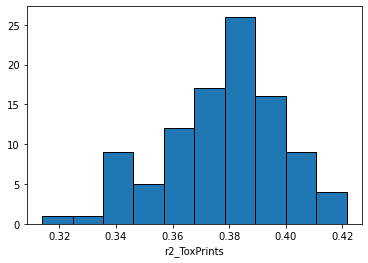

In [31]:
r2_list = [item[0] for item in txp_stats]
plt.hist(r2_list,linewidth=1,edgecolor='black')
plt.xlabel('r2_ToxPrints')
plt.savefig(figures_dir+'bs_TxPs.png', dpi = 300)

print(np.percentile(r2_list, [2.5, 97.5]))
print(np.mean(r2_list))

[0.31869427 0.37909469]
0.3494722824307482


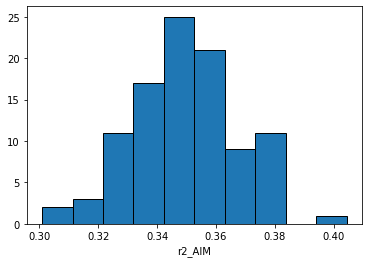

In [32]:
r2_list = [item[0] for item in aim_stats]
plt.hist(r2_list,linewidth=1,edgecolor='black')
plt.xlabel('r2_AIM')
plt.savefig(figures_dir+'bs_AIM.png', dpi = 300)

print(np.percentile(r2_list, [2.5, 97.5]))
print(np.mean(r2_list))

https://stats.stackexchange.com/questions/442563/how-to-statistically-compare-machine-learning-regression-models

https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html

https://towardsdatascience.com/comparing-machine-learning-models-statistical-vs-practical-significance-de345c38b42a

https://stackoverflow.com/questions/54498235/compare-whether-the-difference-between-performance-accuracy-of-2-ml-models-is-st

In [37]:
from scipy import stats
stats.ttest_rel([item[1] for item in aim_stats],[item[1] for item in txp_stats])

Ttest_relResult(statistic=9.070053137772051, pvalue=1.1663822768404807e-14)

In [33]:
import pingouin

In [36]:
paired_test_results = pingouin.ttest(x = [item[1] for item in aim_stats], y = [item[1] for item in txp_stats], paired = True, alternative = 'two-sided') 
print(paired_test_results)

               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  9.070053   99   two-sided  1.166382e-14  [0.01, 0.02]  1.273318   

             BF10  power  
T-test  5.881e+11    1.0  


In [35]:
wilcoxon_test_results = pingouin.wilcoxon(x = [item[1] for item in aim_stats], y = [item[1] for item in txp_stats], alternative = 'two-sided')



# Print Wilcoxon test results
print(wilcoxon_test_results)

          W-val alternative         p-val      RBC    CLES
Wilcoxon  500.0   two-sided  3.381330e-12  0.80198  0.8225


In [257]:
I = FP0.index.intersection(POD0.index)
X,Y = FP0.loc[I],POD0.loc[I,'LD50_LM']
data = pd.concat([X,Y],axis=1)
data.head()
values = data.values
n_iterations = 200
n_size = int(len(X)*0.7)
GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)


In [258]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: 
#DataConversionWarning: Data was converted to boolean for metric jaccard 
#warnings.warn(msg, DataConversionWarning)

stats = []
for i in range(n_iterations):
    train = resample(values, replace=True,n_samples = n_size)
    train_list = train.tolist()
    value_list = values.tolist()
    test = np.array([x for x in value_list if x not in train_list])
    GC1.fit(train[:,:-1], train[:,-1])
    predictions = GC1.predict(test[:,:-1])
    r_2 = r2_score(test[:,-1], predictions)
    rmse = np.sqrt(((test[:,-1]-predictions)**2).mean())
    stats.append([r_2,rmse])

array([0.30775471, 0.38691137])

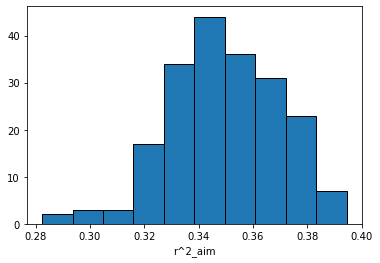

In [259]:
r2_list = [item[0] for item in stats]
plt.hist(r2_list,linewidth=1,edgecolor='black')
plt.xlabel('r^2_aim')

np.percentile(r2_list, [2.5, 97.5])

array([0.68796767, 0.73123305])

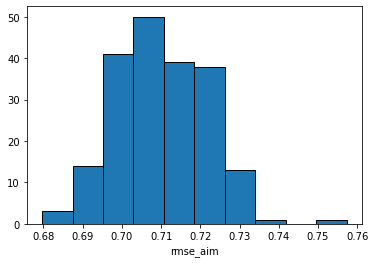

In [260]:
rmse_list = [item[1] for item in stats]
plt.hist(rmse_list,linewidth=1,edgecolor='black')
plt.xlabel('rmse_aim')

np.percentile(rmse_list, [2.5, 97.5])